In [ ]:
!pip install mne
import matplotlib.pyplot as plt
import mne 
from mne.decoding import CSP
from mne.decoding import Scaler
import numpy as np
import os
import pandas as pd
from scipy import io
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Conv2D,ReLU, \
    BatchNormalization,Flatten, Dense,Reshape,\
        Conv2DTranspose, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MeanSquaredError
#from autoencoder_mio import Autoencoder
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


import os
import pickle



import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
%matplotlib inline

     |████████████████████████████████| 6.9 MB 5.5 MB/s 


In [ ]:
from google.colab import  drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Risultati.zip -d /content/Risultati # Replace with your file path

Archive:  /content/drive/MyDrive/Risultati.zip
   creating: /content/Risultati/Risultati/
  inflating: /content/Risultati/Risultati/Processed_P1_pre_test.mat  
  inflating: /content/Risultati/Risultati/Processed_P3_post_training.mat  
  inflating: /content/Risultati/Risultati/Processed_P1_pre_training.mat  
  inflating: /content/Risultati/Risultati/Processed_P3_post_test.mat  
  inflating: /content/Risultati/Risultati/Processed_P2_pre_test.mat  
  inflating: /content/Risultati/Risultati/Processed_P1_post_training.mat  
  inflating: /content/Risultati/Risultati/Processed_P1_post_test.mat  
  inflating: /content/Risultati/Risultati/Processed_P2_post_training.mat  
  inflating: /content/Risultati/Risultati/Processed_P3_pre_training.mat  
  inflating: /content/Risultati/Risultati/Processed_P2_pre_training.mat  
  inflating: /content/Risultati/Risultati/Processed_P3_pre_test.mat  
  inflating: /content/Risultati/Risultati/Processed_P2_post_test.mat  


In [ ]:
path = "/content/Risultati/Risultati" # Replace with your own folder path


data = {"patient1":{"pre":{},
                    "post": {}},
        "patient2":{"pre":{},
                    "post": {}},
        "patient3":{"pre":{},
                    "post": {}}
        }

 
# Patient 1
processed_P1_pre_training = io.loadmat(path + '/Processed_P1_pre_training.mat')
processed_P1_pre_test = io.loadmat(path + '/Processed_P1_pre_test')
processed_P1_post_training= io.loadmat(path + '/Processed_P1_post_training.mat')
processed_P1_post_test= io.loadmat(path + '/Processed_P1_post_test.mat')

# Patient 2
processed_P2_pre_training = io.loadmat(path + '/Processed_P2_pre_training.mat')
processed_P2_pre_test = io.loadmat(path + '/Processed_P2_pre_test')
processed_P2_post_training= io.loadmat(path + '/Processed_P2_post_training.mat')
processed_P2_post_test= io.loadmat(path + '/Processed_P2_post_test.mat')

# Patient 3
processed_P3_pre_training = io.loadmat(path + '/Processed_P3_pre_training.mat')
processed_P3_pre_test = io.loadmat(path + '/Processed_P3_pre_test')
processed_P3_post_training= io.loadmat(path + '/Processed_P3_post_training.mat')
processed_P3_post_test= io.loadmat(path + '/Processed_P3_post_test.mat')

keys = list(processed_P1_pre_training.keys())
for key in keys[:3]:
  processed_P1_pre_training.pop(key)
  processed_P1_pre_test.pop(key)
  processed_P1_post_training.pop(key)
  processed_P1_post_test.pop(key)

  processed_P2_pre_training.pop(key)
  processed_P2_pre_test.pop(key)
  processed_P2_post_training.pop(key)
  processed_P2_post_test.pop(key)

  processed_P3_pre_training.pop(key)
  processed_P3_pre_test.pop(key)
  processed_P3_post_training.pop(key)
  processed_P3_post_test.pop(key)

data["patient1"]["pre"]["train"]= processed_P1_pre_training
data["patient1"]["pre"]["test"]= processed_P1_pre_test
data["patient1"]["post"]["train"] = processed_P1_post_training
data["patient1"]["post"]["test"] = processed_P1_post_test

data["patient2"]["pre"]["train"]= processed_P2_pre_training
data["patient2"]["pre"]["test"]= processed_P2_pre_test
data["patient2"]["post"]["train"] = processed_P2_post_training
data["patient2"]["post"]["test"] = processed_P2_post_test

data["patient3"]["pre"]["train"]= processed_P3_pre_training
data["patient3"]["pre"]["test"]= processed_P3_pre_test
data["patient3"]["post"]["train"] = processed_P3_post_training
data["patient3"]["post"]["test"] = processed_P3_post_test

Per ogni sessione abbiamo:

* frequenza di campionamento (256 hz)
* 40 samples di mano destra (40 campioni x 16 canali x 2048 campioni)
* 40 samples a sinistra (40 campioni x 16 canali x 2048 campioni)
* 80 labels y 
Il Dataset é **bilanciato**, non dobbiamo tenerne conto nello score che utilizzeremo, infatti useremo la semplice **Accuracy**.

In [ ]:
def prepare_data(patient='patient1',step='pre'):
  
  X_train=np.concatenate([data[patient][step]['train']['DxFilt'],
                          data[patient][step]['train']['SxFilt']])
  y_train=np.concatenate([0*np.ones(len(data[patient][step]['train']['DxFilt'])),
                            np.ones(len(data[patient][step]['train']['SxFilt']))])
  X_test=np.concatenate([data[patient][step]['test']['DxFilt'],
                          data[patient][step]['test']['SxFilt']])
  y_test=np.concatenate([0*np.ones(len(data[patient][step]['test']['DxFilt'])),
                            np.ones(len(data[patient][step]['test']['SxFilt']))])

  X_train, y_train = shuffle(X_train, y_train, random_state=42)

  y_train = utils.to_categorical(y_train, 2)
  y_test = utils.to_categorical(y_test, 2)


  X_train=X_train.reshape(80,16,2048,1)
  X_test=X_test.reshape(80,16,2048,1)

  return X_train, y_train,X_test,y_test

# Autoencoder


In [ ]:
class Autoencoder:
    """
    Autoencoder represents a Deep Convolutional autoencoder architecture with
    mirrored encoder and decoder components.
    """

    def __init__(self,
                input_shape,
                conv_filters,
                conv_kernels,
                conv_strides,
                latent_space_dim):
        self.input_shape = input_shape #[28,28,1]

        self.conv_filters = conv_filters # [2,4,8] sono liste
        self.conv_kernels = conv_kernels # [3,5,3]
        self.conv_strides = conv_strides # [1,2,2]

        self.latent_space_dim = latent_space_dim #2

  #questi saranno modelli keras
        self.encoder = None 
        self.decoder = None
        self.model = None


        #private attributes
        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None 
        self._model_input = None 

        self._build() # metodo per costruire encoder encoder e model


    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary() 



    def compile(self,learning_rate=0.0001):
        # 1. optimizer
        optimizer = Adam(learning_rate=learning_rate)
        mse_loss = MeanSquaredError() 
        self.model.compile(optimizer=optimizer,loss=mse_loss)

    def train(self,x_train,batch_size,num_epochs):
        history=self.model.fit(x_train,
                        x_train,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        shuffle=True)
        PLOT==True
        if PLOT==True:
            plt.plot(history.history['loss'])
            #plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train'], loc='upper left')
            plt.show()
        
    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(latent_representations)
        return reconstructed_images, latent_representations
        
    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = Autoencoder(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)



    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input=encoder_input
        self.encoder = Model(encoder_input, bottleneck, name='encoder')
    
    def _add_encoder_input(self):
        return Input(shape=self.input_shape,name='encoder_input')
    
    def _add_conv_layers(self,encoder_input):
        """
        create all convolutional blocks in encoder
        """
        x = encoder_input
        
        #for loop through all the conv layers
        for layer_index in range(self._num_conv_layers):
            #x é un graph di layer
            x = self._add_conv_layer(layer_index, x)
        return x
    
    def _add_conv_layer(self,layer_index, x):
        """  Adds a convolutional block to a graph of layers,
        consisting of:
        conv 2d + reLU + batch normalization
        é un blocco abbastanza standard
        """
        layer_number = layer_index + 1
        conv_layer = Conv2D(
                filters=self.conv_filters[layer_index],
                kernel_size=self.conv_kernels[layer_index],
                strides=self.conv_strides[layer_index],
                padding='same',
                name = f'encoder_conv_layer_{layer_number}'
        )
        x = conv_layer(x)
        #un relu layer 
        x = ReLU(name=f'encoder_relu_{layer_number}')(x)

        x= BatchNormalization(name=f"encoder_bn_{layer_number }")(x)
        return  x

    def _add_bottleneck(self, x,):
        """  flatten data and bottleneck (Dense layer)

        """
        self._shape_before_bottleneck = K.int_shape(x)[1:] #[2,7,7,32]
        #2 é il batch che non ci interessa 
        x = Flatten()(x)
        x = Dense(self.latent_space_dim,name = "encoder_output")(x)

        return x

    def _build_decoder(self):

        decoder_input = self._add_decoder_input()

        dense_layer  = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layer = self._add_conv_transpose_layers(reshape_layer)

        decoder_output = self._add_decoder_output(conv_transpose_layer)
        
        self.decoder = Model(decoder_input,decoder_output, name= 'decoder')
        
    
    def _add_decoder_input(self):
         return Input(shape=self.latent_space_dim,name='decoder_input')
    
    def _add_dense_layer(self ,decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) #[4,4,32] -> 4*4*32
        dense_layer = Dense(num_neurons,name='decoder_dense')(decoder_input)
        return dense_layer

    def _add_reshape_layer(self,dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self,x):
        """Add convolution trasnpose blocks  l opposto del encoder
            looping through all the conv layers in reverse and stop at the 1st layer

        """
        for layer_index in reversed(range(1,self._num_conv_layers)):
            # [0,1,2] -> [2,1,0] -> [2,1]
            x = self._add_conv_transpose_layer(layer_index,x)
        return x

    def _add_conv_transpose_layer(self,layer_index,x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
            )
        x = conv_transpose_layer(x)
        x = ReLU(name=f'decoder_relu_{layer_num}')(x)
        x = BatchNormalization(name=f'decoder_bn_{layer_num}')(x)
        return x

    def _add_decoder_output(self,x):
        #sigmoid function instead of relu but why?
        # vogl
        conv_transpose_layer = conv_transpose_layer = Conv2DTranspose(
            filters=1, #[24,24,1] stessa del input shape voglio un solo channel
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0], #first convolution layer
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
            )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name='sigmoid_layer')(x)
        return output_layer
        
    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input,model_output, name='autoencoder')

# make spectro

In [ ]:
def make_spectro(patient='patient1',step='pre',mode='train'):

  X=np.concatenate([data[patient][step][mode]['DxFilt'],
                        data[patient][step][mode]['SxFilt']])
  
  y=np.concatenate([0*np.ones(len(data[patient][step][mode]['DxFilt'])),
                          np.ones(len(data[patient][step][mode]['SxFilt']))])

  fs = 256 

  temp = []
  label = []
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      x=X[i,j,:]
      label.append(y[i])
      f, t, Zxx = signal.stft(x, fs,nperseg=64) 
      print(Zxx.shape)
      temp.append(np.abs(Zxx)[1:,:16])


  X=np.array(temp)
  y=np.array(label)
  x = X.reshape(X.shape + (1,))
  plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')  
  return x,y

In [ ]:
x,y=make_spectro()
x.shape

NameError: ignored

#CODE

In [ ]:
input_shape = (32,16,1)
learning_rate = 0.001
epochs = 400
batch_size = 32

autoencoder = Autoencoder(
    input_shape=input_shape,
    conv_filters=(32, 64, 64, 64),
    conv_kernels=(3, 3, 3, 3),
    conv_strides=(1, 2, 2, 1),
    latent_space_dim=50
)

autoencoder.summary()
autoencoder.compile(learning_rate)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 16, 1)]       0         
_________________________________________________________________
encoder_conv_layer_1 (Conv2D (None, 32, 16, 32)        320       
_________________________________________________________________
encoder_relu_1 (ReLU)        (None, 32, 16, 32)        0         
_________________________________________________________________
encoder_bn_1 (BatchNormaliza (None, 32, 16, 32)        128       
_________________________________________________________________
encoder_conv_layer_2 (Conv2D (None, 16, 8, 64)         18496     
_________________________________________________________________
encoder_relu_2 (ReLU)        (None, 16, 8, 64)         0         
_________________________________________________________________
encoder_bn_2 (BatchNormaliza (None, 16, 8, 64)         256 

Epoch 1/200
40/40 [==============================] - 2s 14ms/step - loss: 0.3234
Epoch 2/200
40/40 [==============================] - 0s 11ms/step - loss: 0.2857
Epoch 3/200
40/40 [==============================] - 0s 11ms/step - loss: 0.2854
Epoch 4/200
40/40 [==============================] - 0s 11ms/step - loss: 0.2851
Epoch 5/200
40/40 [==============================] - 0s 11ms/step - loss: 0.2846
Epoch 6/200
40/40 [==============================] - 0s 11ms/step - loss: 0.2841
Epoch 7/200
40/40 [==============================] - 0s 11ms/step - loss: 0.2837
Epoch 8/200
40/40 [==============================] - 0s 11ms/step - loss: 0.2831
Epoch 9/200
40/40 [==============================] - 0s 10ms/step - loss: 0.2820
Epoch 10/200
40/40 [==============================] - 0s 11ms/step - loss: 0.2804
Epoch 11/200
40/40 [==============================] - 0s 11ms/step - loss: 0.2798
Epoch 12/200
40/40 [==============================] - 0s 11ms/step - loss: 0.2793
Epoch 13/200
40/40 [=====

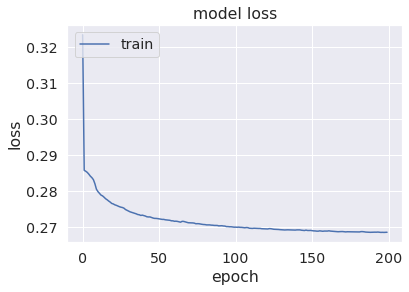

In [ ]:
autoencoder.train(x,batch_size,200)
autoencoder.save("model")

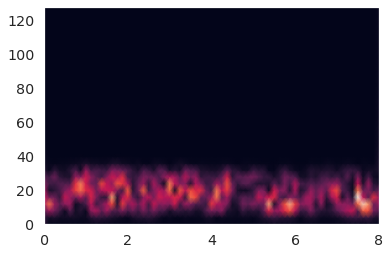

In [ ]:
autoencoder = Autoencoder.load("model")

x_test,y_test = make_spectro(patient='patient1',step='pre',mode='test')

_,latent=autoencoder.reconstruct(x_test)


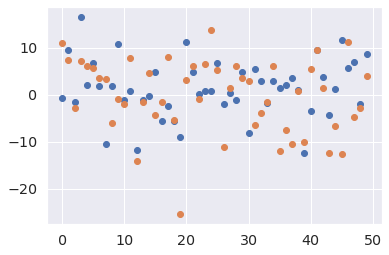

In [ ]:
plt.plot(latent[0,:],'o')
plt.plot(latent[90,:],'o')

In [ ]:
image_new=image_new.reshape((128,16))
plt.pcolormesh(t[:16], f[:128], image_new, shading='gouraud')  

(1280, 50)

In [ ]:
x_test=x_test[5,:,:,:].reshape((1,32,16,1))
image_new,_=autoencoder.reconstruct(x_test)
image_new=image_new.reshape((128,16))
plt.pcolormesh(t[:16], f[:128], image_new, shading='gouraud')  


ValueError: ignored